<h1>Project: a CNN to Histopathologic Cancer Detection</h1>
<p><b>Author:</b> Sebastian Gomez Ahumada</p>

<p> AI allows users to improve actual diagnosis systems in all the fields of knowledge; cancer detection is one of the most complex tasks and it can lead to misdiagnosis of many patients due to medical error. However, the improvement of the identification of cancer through AI allows doctors to take better decisions and give better treatments to their patients. In consequence, the accuracy and precision of the AI algorithm is a critical factor in the diagnosis due to the fact that human lifes are relying on an algorithm.</p>
<p> In this project, I propose a CNN approach to detect cancer based on kaggle Mini-Project <b>Histopathologic Cancer Detection</b> to identify metastatic tissue in histopathologic scans of lymph node sections.</p>

<h2>Database:</h2>

In [1]:
#Download Data

import os
data_url = 'https://www.kaggle.com/competitions/histopathologic-cancer-detection/data' #The URL where we are going to retrieve the data

"""Open datasets is a library that allows the user to download datasets form kaggle, public drives, etc. 
The documentation is in https://pypi.org/project/opendatasets/"""

os.system('pip install opendatasets') #Install opendatasets in case we dont have it
import opendatasets as od
od.download(data_url) #You must have a kaggle account and an API key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading histopathologic-cancer-detection.zip to .\histopathologic-cancer-detection


100%|██████████| 6.31G/6.31G [12:02<00:00, 9.37MB/s]  



Extracting archive .\histopathologic-cancer-detection/histopathologic-cancer-detection.zip to .\histopathologic-cancer-detection


TRAIN DATASET
Number of images with cancer: 89117	 Proportion: 40.5%
Number of images without cancer: 130908	 Proportion: 59.5%

TEST
Number of images in test path: 57458


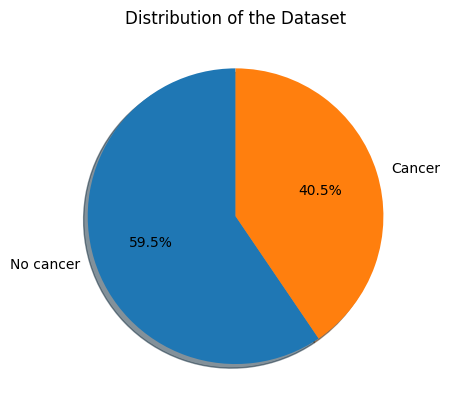

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from keras.optimizers.legacy.adam import Adam
from keras.losses import MeanSquaredLogarithmicError
from keras.metrics import Recall, AUC
from PIL.Image import open
import random
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import glob, os
import visualkeras

files_route = 'histopathologic-cancer-detection'

#TRAIN INFORMATION
train_csv = pd.read_csv(os.path.join(files_route,'train_labels.csv'))
count_present_cancer = len(train_csv[train_csv["label"] > 0])
count_absent_cancer = len(train_csv[train_csv["label"] == 0])

weight_present_cancer = count_present_cancer/len(train_csv)
weight_absent_cancer = count_absent_cancer/len(train_csv)
print("TRAIN DATASET")
print(f"Number of images with cancer: {count_present_cancer}\t Proportion: {round(weight_present_cancer*100,2)}%" )
print(f"Number of images without cancer: {count_absent_cancer}\t Proportion: {round(weight_absent_cancer*100,2)}%" )

#TEST INFORMATION
test_path = glob.glob(os.path.join(files_route,"test","*.tif"))

print(f"\nTEST\nNumber of images in test path: {len(test_path)}")

plt.figure()
plt.pie(train_csv['label'].value_counts(), labels=['No cancer', 'Cancer'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Distribution of the Dataset")
plt.show()

<p>The dataset is composed of TIF images (.tif) and the file name is the identifier in the train_labels.csv; when we analize the dataset we observe that it is not balanced and this can lead to misclasification and inadequate metrics, we are going to train the CNN with 2000 images due to low resources and in order to keep the database balanced</p>

In [15]:
#We are going to create a new path with a sub dataset of random images from train but with equal proportion
#of images with and without cancer


#Create a new folder
new_folder = os.path.join(files_route,"train_sub")
os.mkdir(new_folder)

#Create a new folder for each class
os.mkdir(os.path.join(new_folder,"0"))
os.mkdir(os.path.join(new_folder,"1"))

#Get the images with cancer
cancer_images = train_csv[train_csv["label"] > 0]["id"]
#Get the images without cancer
no_cancer_images = train_csv[train_csv["label"] == 0]["id"]

#Get a random sample of images with cancer
cancer_images = random.sample(list(cancer_images), 1000)
#Get a random sample of images without cancer
no_cancer_images = random.sample(list(no_cancer_images), 1000)

#Copy the images to the new folder
for image in cancer_images:
    image_handle = open(os.path.join(files_route,"train",image+".tif"))
    image_handle.save(os.path.join(new_folder,"1",'1_'+image+".png"),"png")
for image in no_cancer_images:
    image_handle = open(os.path.join(files_route,"train",image+".tif"))
    image_handle.save(os.path.join(new_folder,"0",'0_'+image+".png"),"png")

#Create a new train csv with the new images
new_train_csv = pd.DataFrame(columns=["id","label"])
for image in cancer_images:
    new_train_csv = new_train_csv.append({"id":image,"label":1},ignore_index=True)
for image in no_cancer_images:
    new_train_csv = new_train_csv.append({"id":image,"label":0},ignore_index=True)
new_train_csv.to_csv(os.path.join(new_folder,"train_labels.csv"),index=False)


C:\Users\gomezahs\AppData\Local\Temp\ipykernel_13680\1760414290.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_csv = new_train_csv.append({"id":image,"label":1},ignore_index=True)
C:\Users\gomezahs\AppData\Local\Temp\ipykernel_13680\1760414290.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_csv = new_train_csv.append({"id":image,"label":1},ignore_index=True)
C:\Users\gomezahs\AppData\Local\Temp\ipykernel_13680\1760414290.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_csv = new_train_csv.append({"id":image,"label":1},ignore_index=True)
C:\Users\gomezahs\AppData\Local\Temp\ipykernel_13680\1760414290.py:34: FutureWarning: The frame.append method is deprecated and will be removed f

In [4]:
#Now, we are going to define some parameters such as image dimension and load our dataset from tensorflow 
import tensorflow as tf
from PIL.Image import open

#We are going to define the image dimension
new_folder = os.path.join(files_route,"train_sub")
data_route = os.path.join(new_folder,"*","*.png")
img_dim = open(glob.glob(data_route)[0]).size
batch_size = 32

#We are going to load the dataset with the utils function for PNG's
training_dataset, valid_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(files_route,'train_sub'),labels='inferred',
                                                              label_mode='int',class_names = None,
                                                              batch_size = batch_size, image_size=img_dim,
                                                              shuffle=True,seed = 42, validation_split=0.2,subset = 'both')

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


In [17]:
#We are going to define the model, in first place, we are going to use a fixed learning rate and 2 or 3 blocks of 
# [Convolution - Convolution - Max pooling]_n with batch normalization.

learning_rate = 0.001
model_optimizer = Adam(learning_rate=learning_rate)

def model_definition(n_capas):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_dim[0], img_dim[1], 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    for i in range(n_capas):
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D())
        model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))
    model.compile(optimizer=model_optimizer, loss= MeanSquaredLogarithmicError(), metrics=['accuracy'])
    return model

model = model_definition(2)
model_2 = model_definition(3)

<h2><b>First model:<b> Architecture with 2 Conv layers.<h2>

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 44, 44, 32)        9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 42, 42, 32)       

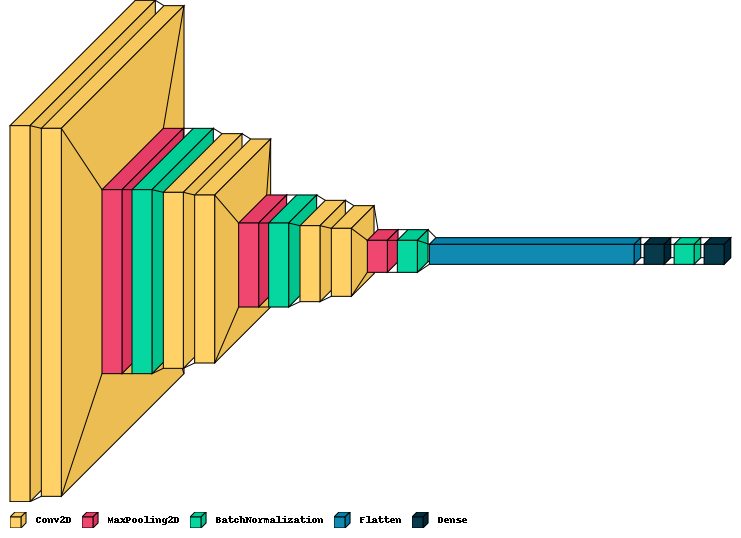

In [18]:
model.summary()
visualkeras.layered_view(model, legend=True)

<h2><b>Second model:<b> Architecture with 3 Conv layers.<h2>

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_21 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 46, 46, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 44, 44, 32)        9248      
                                                                 
 conv2d_23 (Conv2D)          (None, 42, 42, 32)       

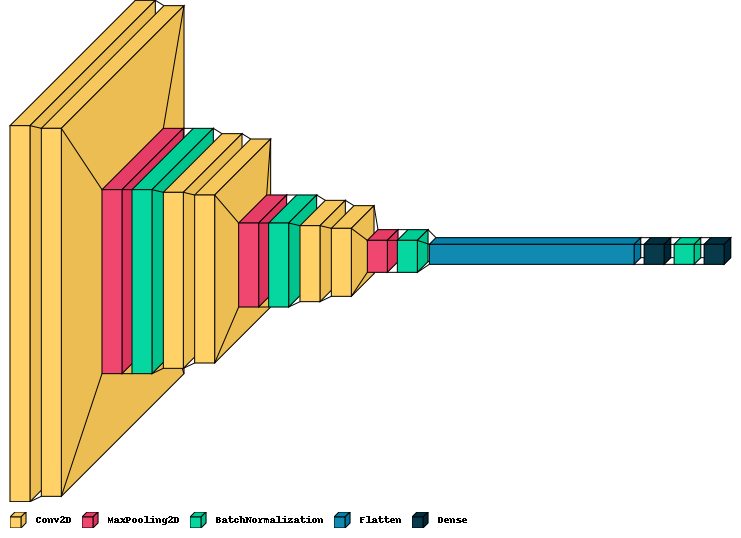

In [19]:
model_2.summary()
visualkeras.layered_view(model, legend=True)

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#We are going to train both models with the same parameters
epochs = 20

history = model.fit(training_dataset, epochs=epochs, validation_data=valid_dataset, 
                    callbacks = [ModelCheckpoint("model_1.tf","val_accuracy", save_best_only=True), 
                                 EarlyStopping("val_accuracy", patience=2)])

histoy_2 = model_2.fit(training_dataset, epochs=epochs, validation_data=valid_dataset, 
                       callbacks = [ModelCheckpoint("model_2.tf","val_accuracy", save_best_only=True), 
                                    EarlyStopping("val_accuracy", patience=2)])



#We define the functions to plot accuracy and loss for each model 

def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 1.2501 - accuracy: 0.7244

INFO:tensorflow:Assets written to: model_1.tf\assets


INFO:tensorflow:Assets written to: model_1.tf\assets


50/50 [==============================] - 42s 798ms/step - loss: 1.2501 - accuracy: 0.7244 - val_loss: 0.6078 - val_accuracy: 0.4550
Epoch 2/20
50/50 [==============================] - 37s 747ms/step - loss: 0.2385 - accuracy: 0.7781 - val_loss: 0.2461 - val_accuracy: 0.4550
Epoch 3/20
50/50 [==============================] - 39s 777ms/step - loss: 0.1201 - accuracy: 0.7806 - val_loss: 0.2215 - val_accuracy: 0.4550
Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.7297 - accuracy: 0.7025

INFO:tensorflow:Assets written to: model_2.tf\assets


INFO:tensorflow:Assets written to: model_2.tf\assets


50/50 [==============================] - 44s 850ms/step - loss: 0.7297 - accuracy: 0.7025 - val_loss: 0.4815 - val_accuracy: 0.4550
Epoch 2/20
50/50 [==============================] - 38s 754ms/step - loss: 0.2042 - accuracy: 0.7538 - val_loss: 0.2168 - val_accuracy: 0.4550
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.7681

INFO:tensorflow:Assets written to: model_2.tf\assets


INFO:tensorflow:Assets written to: model_2.tf\assets


50/50 [==============================] - 42s 845ms/step - loss: 0.1192 - accuracy: 0.7681 - val_loss: 0.1681 - val_accuracy: 0.4675
Epoch 4/20
50/50 [==============================] - 37s 744ms/step - loss: 0.0952 - accuracy: 0.7700 - val_loss: 0.1468 - val_accuracy: 0.4450
Epoch 5/20
50/50 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.7431

INFO:tensorflow:Assets written to: model_2.tf\assets


INFO:tensorflow:Assets written to: model_2.tf\assets


50/50 [==============================] - 42s 839ms/step - loss: 0.0967 - accuracy: 0.7431 - val_loss: 0.1811 - val_accuracy: 0.4825
Epoch 6/20
50/50 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.7794

INFO:tensorflow:Assets written to: model_2.tf\assets


INFO:tensorflow:Assets written to: model_2.tf\assets


50/50 [==============================] - 43s 866ms/step - loss: 0.0846 - accuracy: 0.7794 - val_loss: 0.1143 - val_accuracy: 0.5850
Epoch 7/20
50/50 [==============================] - 37s 739ms/step - loss: 0.0820 - accuracy: 0.7781 - val_loss: 0.1565 - val_accuracy: 0.4650
Epoch 8/20
50/50 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.8131

INFO:tensorflow:Assets written to: model_2.tf\assets


INFO:tensorflow:Assets written to: model_2.tf\assets


50/50 [==============================] - 41s 823ms/step - loss: 0.0726 - accuracy: 0.8131 - val_loss: 0.1105 - val_accuracy: 0.6700
Epoch 9/20
50/50 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.8200

INFO:tensorflow:Assets written to: model_2.tf\assets


INFO:tensorflow:Assets written to: model_2.tf\assets


50/50 [==============================] - 42s 846ms/step - loss: 0.0701 - accuracy: 0.8200 - val_loss: 0.1023 - val_accuracy: 0.6875
Epoch 10/20
50/50 [==============================] - 39s 774ms/step - loss: 0.0698 - accuracy: 0.8138 - val_loss: 0.1378 - val_accuracy: 0.5400
Epoch 11/20
50/50 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.8294

INFO:tensorflow:Assets written to: model_2.tf\assets


INFO:tensorflow:Assets written to: model_2.tf\assets


50/50 [==============================] - 40s 805ms/step - loss: 0.0654 - accuracy: 0.8294 - val_loss: 0.0783 - val_accuracy: 0.7950
Epoch 12/20
50/50 [==============================] - 37s 733ms/step - loss: 0.0597 - accuracy: 0.8512 - val_loss: 0.0976 - val_accuracy: 0.7275
Epoch 13/20
50/50 [==============================] - 35s 698ms/step - loss: 0.0644 - accuracy: 0.8381 - val_loss: 0.1093 - val_accuracy: 0.7350


<h2>Results first model</h2>

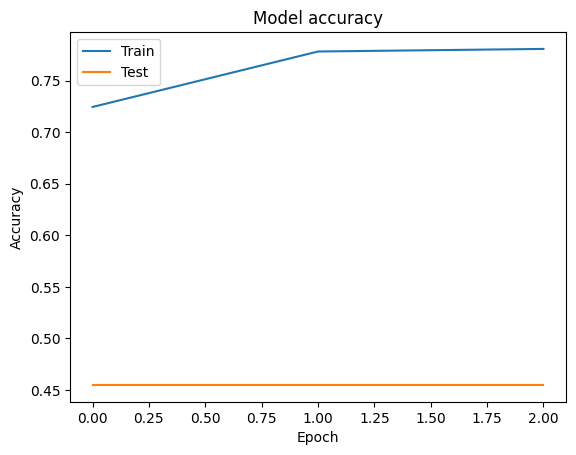

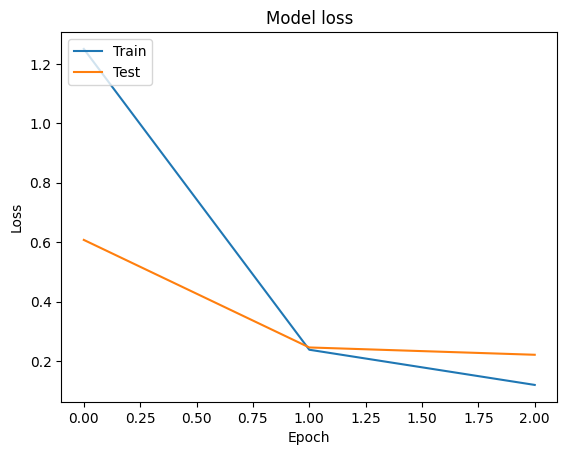

In [21]:
plot_acc(history)
plot_loss(history)

<h2>Results second model</h2>

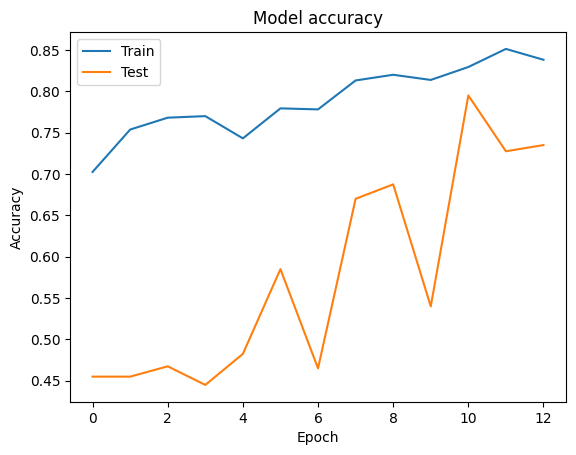

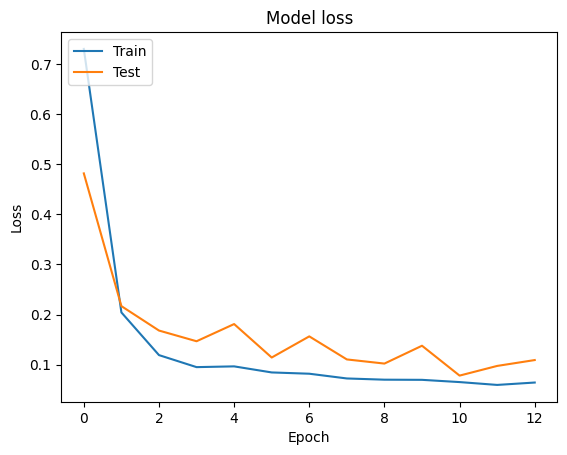

In [23]:
plot_acc(histoy_2)
plot_loss(histoy_2)

<h2>Now we are going to train the best model (second) with different learning rates</h2>

In [5]:
def model_definition(n_capas, learning_rate):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_dim[0], img_dim[1], 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    for i in range(n_capas):
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D())
        model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))
    model_optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=model_optimizer, loss= MeanSquaredLogarithmicError(), metrics=['accuracy'])
    return model

model_1 = model_definition(3,0.001)
model_2 = model_definition(3,0.01)

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 20

history = model_1.fit(training_dataset, epochs=epochs, validation_data=valid_dataset, 
                      callbacks = [ModelCheckpoint("model_1.tf","val_accuracy", save_best_only=True), 
                                   EarlyStopping("val_accuracy", patience=3)])

histoy_2 = model_2.fit(training_dataset, epochs=epochs, validation_data=valid_dataset, 
                       callbacks = [ModelCheckpoint("model_2.tf","val_accuracy", save_best_only=True), 
                                    EarlyStopping("val_accuracy", patience=3)])

#We define the functions to plot accuracy and loss for each model 

def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


Epoch 1/20
 2/50 [>.............................] - ETA: 39s - loss: 1.3923 - accuracy: 0.7188 

KeyboardInterrupt: 

<h2><b>Results first model:</b> Lr = 0.001</h2>

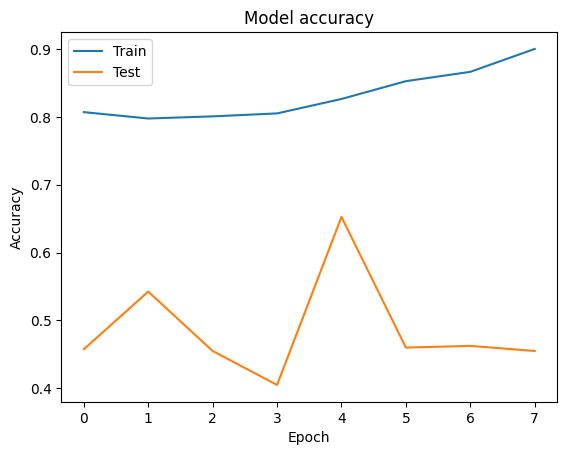

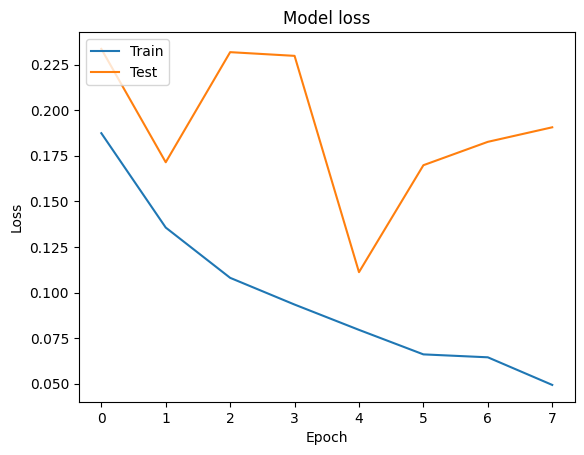

In [27]:
plot_acc(history)
plot_loss(history)

<h2><b>Results second model: </b>Lr = 0.01</h2>

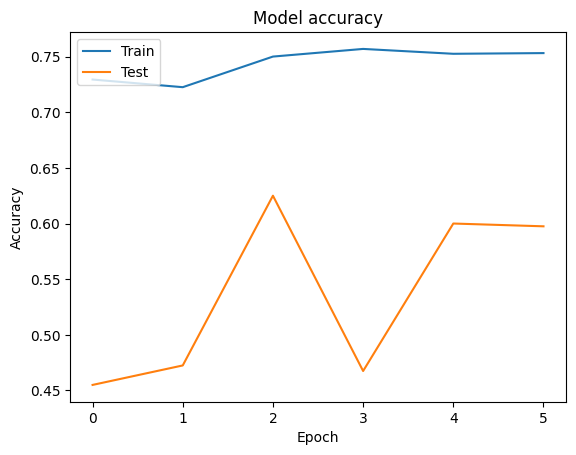

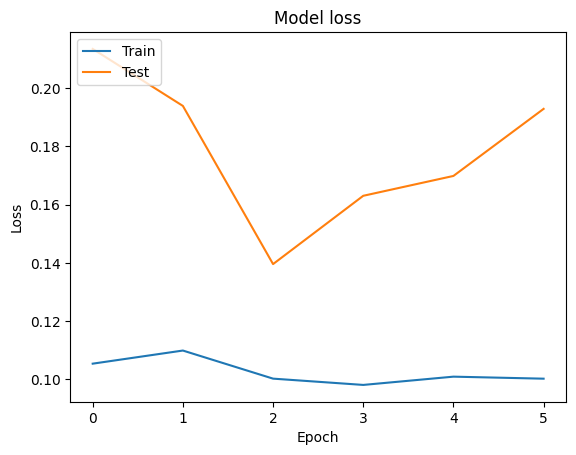

In [28]:
plot_acc(histoy_2)
plot_loss(histoy_2)

<p> Now we arwe going to train a last model with the best parameters and a bigger dataset in order to make it more robust and accurate </p>

<h4><b>Parameters:</b></h4>
<p>Learning rate: 0.01</p>
<p>Number of blocks: 3</p>

In [3]:
#We are going to create the dataset to train the definitive model, the model is going to be trained with 20000 images in a 
#balanced dataset.


#Create a new folder
new_folder = os.path.join(files_route,"train_sub_big")
os.mkdir(new_folder)

#Create a new folder for each class
os.mkdir(os.path.join(new_folder,"0"))
os.mkdir(os.path.join(new_folder,"1"))

#Get the images with cancer
cancer_images = train_csv[train_csv["label"] > 0]["id"]
#Get the images without cancer
no_cancer_images = train_csv[train_csv["label"] == 0]["id"]

#Get a random sample of images with cancer
cancer_images = random.sample(list(cancer_images), 10000)
#Get a random sample of images without cancer
no_cancer_images = random.sample(list(no_cancer_images), 10000)

#Copy the images to the new folder
for image in cancer_images:
    image_handle = open(os.path.join(files_route,"train",image+".tif"))
    image_handle.save(os.path.join(new_folder,"1",'1_'+image+".png"),"png")
for image in no_cancer_images:
    image_handle = open(os.path.join(files_route,"train",image+".tif"))
    image_handle.save(os.path.join(new_folder,"0",'0_'+image+".png"),"png")

#Create a new train csv with the new images
new_train_csv = pd.DataFrame(columns=["id","label"])
for image in cancer_images:
    new_train_csv = new_train_csv.append({"id":image,"label":1},ignore_index=True)
for image in no_cancer_images:
    new_train_csv = new_train_csv.append({"id":image,"label":0},ignore_index=True)
new_train_csv.to_csv(os.path.join(new_folder,"train_labels.csv"),index=False)


C:\Users\gomezahs\AppData\Local\Temp\ipykernel_20124\2261808946.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_csv = new_train_csv.append({"id":image,"label":1},ignore_index=True)
C:\Users\gomezahs\AppData\Local\Temp\ipykernel_20124\2261808946.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_csv = new_train_csv.append({"id":image,"label":1},ignore_index=True)
C:\Users\gomezahs\AppData\Local\Temp\ipykernel_20124\2261808946.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_train_csv = new_train_csv.append({"id":image,"label":1},ignore_index=True)
C:\Users\gomezahs\AppData\Local\Temp\ipykernel_20124\2261808946.py:30: FutureWarning: The frame.append method is deprecated and will be removed f

In [8]:
import tensorflow as tf

new_folder = os.path.join(files_route,"train_sub_big")
data_route = os.path.join(new_folder,"*","*.png")
img_dim = open(glob.glob(data_route)[0]).size
batch_size = 32

#We are going to load the dataset with the utils function for PNG's
training_dataset, valid_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(files_route,'train_sub_big'),labels='inferred',
                                                              label_mode='int',class_names = None,
                                                              batch_size = batch_size, image_size=img_dim,
                                                              shuffle=True,seed = 42, validation_split=0.2,subset = 'both')

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Using 4000 files for validation.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 44, 44, 32)        9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 42, 42, 32)       

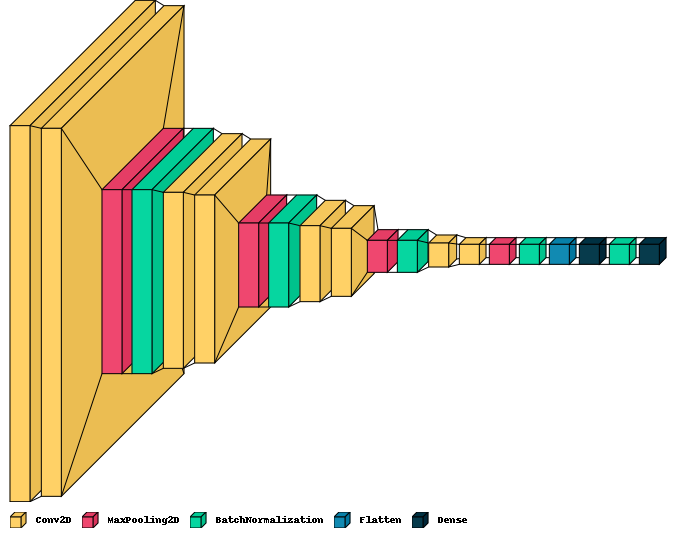

In [9]:
model_def = model_definition(3,0.01)
model_def.summary()
visualkeras.layered_view(model_def,legend=True)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs = 20

history = model_def.fit(training_dataset, epochs=epochs, validation_data=valid_dataset, callbacks = [ModelCheckpoint("model_def.tf","val_accuracy", save_best_only=True), EarlyStopping("val_accuracy", patience=3)])

#We define the functions to plot accuracy and loss for each model 

def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.8288

INFO:tensorflow:Assets written to: model_def.tf\assets


INFO:tensorflow:Assets written to: model_def.tf\assets


500/500 [==============================] - 376s 752ms/step - loss: 0.0621 - accuracy: 0.8288 - val_loss: 0.1840 - val_accuracy: 0.5615
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.8363

INFO:tensorflow:Assets written to: model_def.tf\assets


INFO:tensorflow:Assets written to: model_def.tf\assets


500/500 [==============================] - 357s 714ms/step - loss: 0.0596 - accuracy: 0.8363 - val_loss: 0.1242 - val_accuracy: 0.6725
Epoch 3/20
500/500 [==============================] - 359s 717ms/step - loss: 0.0593 - accuracy: 0.8359 - val_loss: 0.1911 - val_accuracy: 0.5017
Epoch 4/20
500/500 [==============================] - 343s 686ms/step - loss: 0.0579 - accuracy: 0.8382 - val_loss: 0.2185 - val_accuracy: 0.5175
Epoch 5/20
500/500 [==============================] - 332s 663ms/step - loss: 0.0566 - accuracy: 0.8457 - val_loss: 0.1703 - val_accuracy: 0.5548


<h3>Results of the best model</h3>

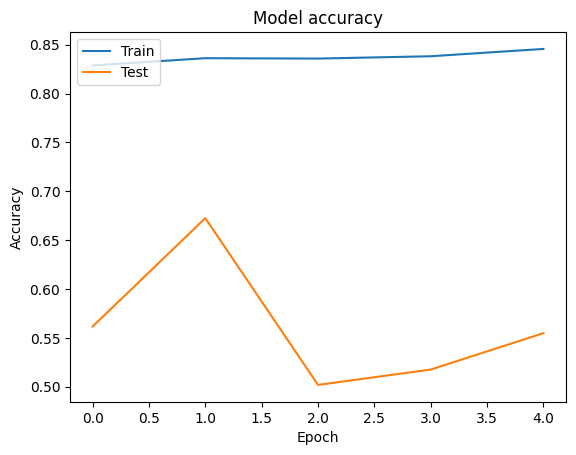

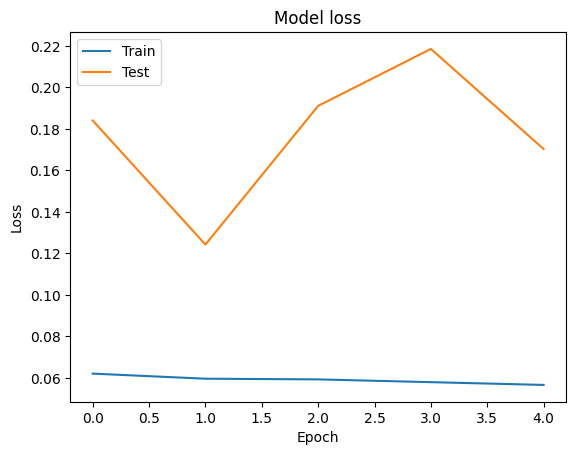

In [13]:
plot_acc(history)
plot_loss(history)

<p>Finally, we are going to make predictions over the test dataset and generate the csv doc to upload to kaggle</p>

In [29]:
# load and prepare the image
def load_image(filename_dir):
    container_imgs = np.zeros((len(filename_dir),96,96,3))
    labels = []
    # load the image
    for i in range(len(filename_dir)):
        labels.append(filename_dir[i].split(os.path.sep)[-1])
        img = load_img(filename_dir[i], target_size=img_dim)
        # convert to array
        img = img_to_array(img)
        # reshape into a single sample with 3 channels
        img = img.reshape(1, img_dim[0], img_dim[1], 3)
        # center pixel data
        img = img.astype('float32')
        container_imgs[i,:,:,:] = img
    return container_imgs, labels

# load an image and predict the class
ruta_test = glob.glob(os.path.join(files_route,"test","*.tif"))
prueba_imgs, label_img = load_image(ruta_test)

In [30]:
from tensorflow.keras.models import load_model

#Load the best model
model_saved = load_model('model_def.tf')    

predictions = model_saved.predict(prueba_imgs)

"""
The prediction is a value between 0 and 1 corresponding to the probability of an image of having cancer,
so we make the label 0 for values smaller than 0.5 and 1 for values greater or equal than 0.5
"""
predictions[np.where(predictions < 0.5)] = 0
predictions[np.where(predictions >= 0.5)] = 1

datos_dic = {'id':label_img,'label':predictions.flatten().astype(int)}

data_predict = pd.DataFrame.from_dict(datos_dic)

#We transform the id of the imgs by eliminating the ".tif" ending of the name
data_predict['id'] = list(map(lambda x: x.split(".")[0],data_predict['id']))

1796/1796 [==============================] - 274s 152ms/step
                                                 id  label
0      00006537328c33e284c973d7b39d340809f7271b.tif      1
1      0000ec92553fda4ce39889f9226ace43cae3364e.tif      1
2      00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif      1
3      000253dfaa0be9d0d100283b22284ab2f6b643f6.tif      0
4      000270442cc15af719583a8172c87cd2bd9c7746.tif      0
...                                             ...    ...
57453  fffdd1cbb1ac0800f65309f344dd15e9331e1c53.tif      0
57454  fffdf4b82ba01f9cae88b9fa45be103344d9f6e3.tif      0
57455  fffec7da56b54258038b0d382b3d55010eceb9d7.tif      0
57456  ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6.tif      1
57457  ffffeb4c0756098c7f589b7beec08ef1899093b5.tif      0

[57458 rows x 2 columns]
Con cancer: 22976      Sin cancer: 34482


<p>In conclusion, we developt a model for cancer detection with a subset of data and with many limitations, some improvements will include run the training over all the train dataset and include more blocks of convolutional layers; also, techniques such as dropout will help to the model</p>